# FIGURE 2

In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.cross_decomposition import PLSRegression
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
from msresist.parameter_tuning import MSclusPLSR_tuning
from msresist.plsr import Q2Y_across_components, R2Y_across_components
from msresist.figures.figure2 import plotR2YQ2Y, plotMixedClusteringPLSR_GridSearch, plotMeasuredVsPredicted, plotScoresLoadings, plotclusteraverages
from msresist.clustering import MassSpecClustering
from msresist.sequence_analysis import preprocess_seqs, FormatName, pYmotifs
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from msresist.pre_processing import preprocessing, MergeDfbyMean, LinearFoldChange, FoldChangeToControl, MapOverlappingPeptides, BuildMatrix, TripsMeanAndStd, CorrCoefFilter
from msresist.FileExporter import create_download_link
import warnings
warnings.simplefilter("ignore")

### Importing and Pre-processing Data

### Phosphorylation measurements:

In [2]:
# pd.set_option('display.max_colwidth', 1000)
# pd.set_option('display.max_rows', 1000)

ABC = preprocessing(motifs=True, Vfilter=True, FCfilter=True, log2T=True)
ABC = preprocess_seqs(ABC, "Y").sort_values(by="Protein")

data = ABC.iloc[:, 6:].T
info = ABC.iloc[:, :6]

In [3]:
ABC

,Protein,Sequence,UniprotAcc,Position,r2_Std,BioReps,PC9,Erl,R428,Erl/R428,Erl+HGF,Erl+FGF,Erl+IGF,KO Erl,KO R428,KO Erl/R428
0,"1-phosphatidylinositol 4,5-bisphosphate phosph...",RNPGFyVEANP,P19174,Y783-p,NA,1,0.891610,-0.132290,0.508638,-0.431225,-0.008149,0.338497,-0.481326,-0.713501,0.547278,-0.519532
3,14-3-3 protein epsilon,GDYHRyLAEFA,P62258,Y131-p,NA,1,0.413272,0.620284,0.352508,-0.291815,0.122734,0.216532,0.167650,-0.586405,-0.395571,-0.619189
4,14-3-3 protein zeta/delta,LLSVAyKNVVG,P63104,Y48-p,NA,1,2.028584,1.620221,1.301309,-0.568873,-0.712916,-0.731959,-0.791261,-0.762381,-0.574292,-0.808433
15,60S ribosomal protein L22-like 1,TYELRyFQISQ,Q6P5R6,Y108-p,NA,1,-0.050440,-0.157775,-0.042431,0.073614,-0.466527,-0.151340,0.006562,-0.384522,1.342117,-0.169258
16,ADP-ribosylation factor-like protein 11,KtTLLyKLKGH,Q969Q4,Y30-p,0.94,2,0.524947,0.122358,0.153717,-0.546423,0.213311,-0.225130,-0.111816,-0.105150,0.030002,-0.055816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
779,Zinc finger CCCH-type antiviral protein 1,LLSSDyRIING,Q7Z2W4,Y410-p,NA,1,2.169358,1.570918,0.620437,-1.374179,0.289226,-0.012489,0.232086,-0.981527,-1.024902,-1.488927
782,Zinc finger protein 185,LFVKEyVNASE,O15231,Y581-p,0.96,2,2.694753,0.852521,0.959014,-1.434426,0.582779,-0.266371,-0.040972,-1.194264,-0.760311,-1.392723
783,Zinc finger protein 185,PVSARySNVSS,O15231,Y597-p,NA,1,0.577963,0.026361,0.046690,0.203022,0.399508,0.017095,-0.176009,-0.181494,-0.215097,-0.698038
781,Zinc finger protein 185,GALADyEGKDV,O15231,Y408-p,NA,1,1.316789,0.388504,0.263724,-1.455803,0.597152,0.022433,0.432893,-0.449084,-0.012254,-1.104353


### Phenotypes

#### Cell Viability:

In [4]:
Y_cv1 = pd.read_csv('./msresist/data/Phenotypic_data/CV_raw3.csv').iloc[:30, :11]
Y_cv2 = pd.read_csv('./msresist/data/Phenotypic_data/CV_raw4.csv').iloc[:29, :11]

for ii in range(1, Y_cv2.columns.size):
    Y_cv1.iloc[:, ii] /= Y_cv1.iloc[0, ii]
    Y_cv2.iloc[:, ii] /= Y_cv2.iloc[0, ii]

Y_cv = MergeDfbyMean(pd.concat([Y_cv1, Y_cv2], axis=0), Y_cv1.columns, "Elapsed")
Y_cv = Y_cv.reset_index()[Y_cv1.columns]
Y_cv = Y_cv[Y_cv["Elapsed"] == 72].iloc[0, 1:]

# Chained MS mixed clustering + PLSR analysis

convergence has not been reached. Clusters: 2 GMMweight: 0.75


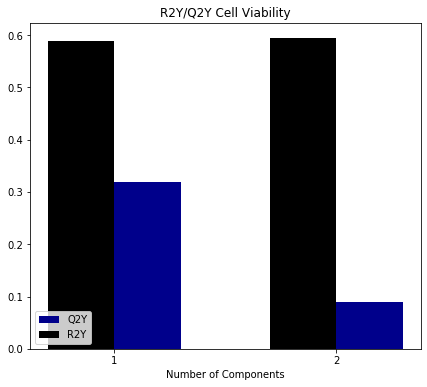

In [5]:
ncl = 2
GMMweight = 0.75

MSC = MassSpecClustering(info, ncl, GMMweight=GMMweight, distance_method="PAM250").fit(data, Y_cv)
centers = MSC.transform(data)

fig, ax = plt.subplots(1, 1, figsize=(7,6))
plotR2YQ2Y(ax, ncl, centers, Y_cv)

In [6]:
ABC_c = ABC.assign(Cluster=[lab+1 for lab in list(MSC.labels_)]).sort_values(by="Sequence")

In [7]:
ABC_c[ABC_c["Protein"].str.contains("Mitogen")]

,Protein,Sequence,UniprotAcc,Position,r2_Std,BioReps,PC9,Erl,R428,Erl/R428,Erl+HGF,Erl+FGF,Erl+IGF,KO Erl,KO R428,KO Erl/R428,Cluster
460,Mitogen-activated protein kinase 14,DEMTGyVATRW,Q16539,Y182-p,0.4,3,-0.589488,-0.206807,-0.419097,-0.367793,0.027512,-0.079849,-0.054700,0.220920,1.069131,0.400168,1
464,Mitogen-activated protein kinase 8,FMMTPyVVTRY,P45983,Y185-p,NA,1,-0.215385,-0.078581,-0.417066,-0.148345,-0.140252,-0.578793,-0.153005,-0.033241,0.982739,0.781929,1
454,Mitogen-activated protein kinase 10,FMMTPyVVTRY,P53779,Y223-p,0.7,2,-0.417625,-0.128913,-0.409535,-0.153588,0.082209,0.081920,-0.133219,0.342055,0.660108,0.076588,1
455,Mitogen-activated protein kinase 10,FMMtPyVVTRY,P53779,Y223-p,NA,1,-0.162438,0.203243,-1.019852,-0.603903,-0.152182,0.085813,0.006449,0.229614,1.150716,0.262540,1
468,Mitogen-activated protein kinase 9,FMMtPyVVTRY,P45984,Y185-p,0.31,3,-0.432164,-0.216767,-0.126941,-0.109546,0.057724,-0.106785,-0.099386,0.219413,0.744633,0.069819,1
465,Mitogen-activated protein kinase 8,FMMtPyVVTRY,P45983,Y185-p,NA,1,-0.339598,-0.529067,-0.462768,-0.393586,0.052149,-0.347747,0.053848,-0.010144,1.070224,0.906689,1
461,Mitogen-activated protein kinase 3,GFLTEyVATRW,P27361,Y204-p,0.38,3,3.012300,-0.900712,-0.120212,-0.798254,1.104433,0.694372,-0.650488,-1.008078,-0.355149,-0.978213,1
452,Mitogen-activated protein kinase 1,GFLTEyVATRW,P28482,Y187-p,0.44,3,3.226947,-1.033155,0.137184,-0.893939,1.347495,0.788650,-0.614984,-1.181102,-0.583727,-1.193370,1
453,Mitogen-activated protein kinase 1,GFLtEyVATRW,P28482,Y187-p,0.65,3,2.536781,-0.511707,-0.243727,-0.302518,0.719232,-0.548508,-0.453016,-0.471604,-0.274320,-0.450614,1
462,Mitogen-activated protein kinase 3,GFLtEyVATRW,P27361,Y204-p,0.67,3,1.212961,-0.257165,-0.095279,-0.113938,0.288827,-0.596804,-0.091697,-0.013589,-0.135719,-0.197598,1


In [8]:
# fig, ax = plt.subplots(1, 1, figsize=(8,6))
# plotMixedClusteringPLSR_GridSearch(ax, data, info, Y_cv)

In [9]:
ncomp = 2

mixedCl_plsr = Pipeline([('mixedCl', MassSpecClustering(info, ncl, GMMweight=GMMweight, distance_method="PAM250")), ('plsr', PLSRegression(ncomp))])

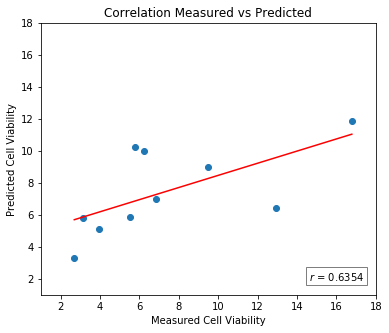

In [10]:
fig, ax = plt.subplots(1,1,figsize=(6,5))
plotMeasuredVsPredicted(ax, mixedCl_plsr, data, Y_cv)

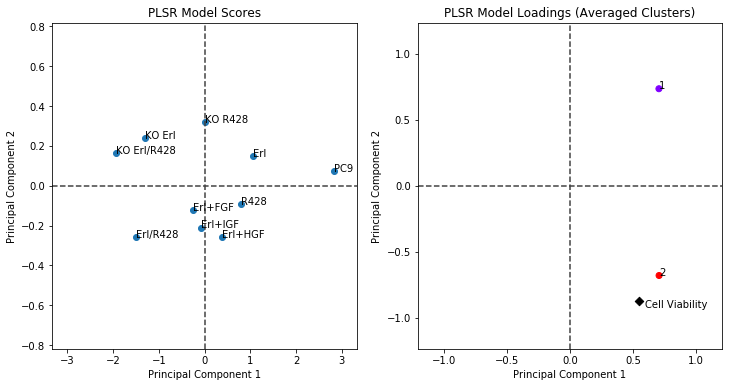

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
colors_ = cm.rainbow(np.linspace(0, 1, ncl))

plotScoresLoadings(ax, mixedCl_plsr, data, Y_cv, ncl, colors_)

In [12]:
clustermembers = mixedCl_plsr.named_steps.mixedCl.clustermembers(ABC.T)
clustermembers

,Cluster_1,seqs_Cluster_1,Condition_Cluster_1,pos_Cluster_1,Cluster_2,seqs_Cluster_2,Condition_Cluster_2,pos_Cluster_2
0,"1-phosphatidylinositol 4,5-bisphosphate phosph...",RNPGFyVEANP,P19174,Y783-p,14-3-3 protein zeta/delta,LLSVAyKNVVG,P63104,Y48-p
1,14-3-3 protein epsilon,GDYHRyLAEFA,P62258,Y131-p,Actin-related protein 3,EPEDHyFLLTE,P61158,Y109-p
2,60S ribosomal protein L22-like 1,TYELRyFQISQ,Q6P5R6,Y108-p,Adapter molecule crk,QEEAEyVRALF,P46108,Y136-p
3,ADP-ribosylation factor-like protein 11,KtTLLyKLKGH,Q969Q4,Y30-p,Afadin,TYTREyFTFPA,P55196,Y1230-p
4,ADP/ATP translocase 2,ANVIRyFPTQA,P05141,Y81-p,Annexin A8,DAETLyKAMKG,P13928,Y31-p
...,...,...,...,...,...,...,...,...
263,Tyrosine-protein phosphatase non-receptor type 11,QNTGDyYDLYG,Q06124,Y62-p,NaN,NaN,NaN,NaN
264,Vasodilator-stimulated phosphoprotein,SRVQIyHNPTA,P50552,Y39-p,NaN,NaN,NaN,NaN
265,Zinc finger protein 185,PVSARySNVSS,O15231,Y597-p,NaN,NaN,NaN,NaN
266,Zinc finger protein 185,GALADyEGKDV,O15231,Y408-p,NaN,NaN,NaN,NaN


In [13]:
create_download_link(clustermembers, "DataClustering")

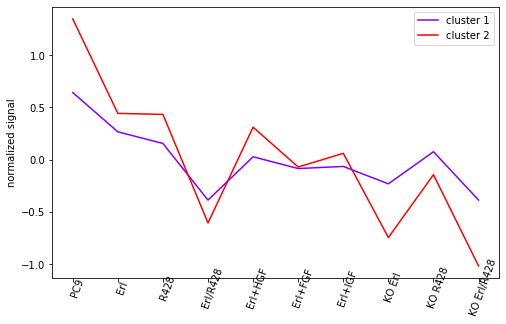

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

plotclusteraverages(ax, ABC, mixedCl_plsr, colors_)